# Final project for "How to win a data science competition" Coursera course

Author: _Nasca, Matías_

(Part 1/2)
_______________

## Content

### [1. Overview](#1.-Overview)

    - 1.1. Description
    - 1.2. Evaluation criteria

    
### [2. Data Source](#2.-Data-Source)

    - 2.1. Access to data
    - 2.2. Quick data visualization¶

### [3. Data Analysis](#3.-Data-Analysis)

    - 3.1. Preliminar preprocessing
    - 3.2. Data description
    - 3.3. Data exploration
    
### [4. Data Enrichment](#4.-Data-Enrichment)

    - 4.1. Text feature extraction
    - 4.2. Categorical encoding
    - 4.3. Rolling features
    - 4.4. Final dataset

In [2]:
#DEPENDENCIES

#generall & utils
import os
import gc
from itertools import product

#data analysis
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocesses
from sklearn.feature_extraction import text
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

In [3]:
#IPYTHON CONFIGURATIONS
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot')
#%matplotlib inline

%load_ext autoreload
%autoreload 2

## 1. Overview

### 1.1. Description

This challenge serves as final project for the ["How to win a data science competition"](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview) for the [Coursera course](https://www.coursera.org/learn/competitive-data-science). This competition face in a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 


_The main goal is to predict total sales for every product and store in the next month._
    
### 1.2. Evaluation criteria

Submissions are qualified by root mean squared error (RMSE).


## 2. Data Source

### 2.1. Access to data

In [4]:
DATA_PATH = './data/raw/'

# train.
sales_train_raw = pd.read_csv(os.path.join(DATA_PATH,'sales_train.csv'))
# test
test_raw = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))
# extra
items_raw = pd.read_csv(os.path.join(DATA_PATH,'items.csv'))
item_categories_raw = pd.read_csv(os.path.join(DATA_PATH,'item_categories.csv'))
shops_raw = pd.read_csv(os.path.join(DATA_PATH,'shops.csv'))

### 2.2. Quick data visualization

In [5]:
print('Sales Train Data')
display(sales_train_raw.head(), sales_train_raw.describe())
print('\n\nTest Data')        
display(test_raw.head(), test_raw.describe())
print('\n\nItems Data')
display(items_raw.head(), items_raw.describe())
print('\n\nItems Categories Data')
display(item_categories_raw.head(), item_categories_raw.describe())
print('\n\nShops Data')
display(shops_raw.head(), shops_raw.describe())

Sales Train Data


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03




Test Data


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000




Items Data


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000




Items Categories Data


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000




Shops Data


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


## 3. Data Analysis

### 3.1. Preliminar preprocessing

First of all, due to test data is generated as `shop_id`-`item_id` combination monthly, train data must be aggregated to allow the match between them.

In [6]:
# shop_id & item_id combinations (for every month)
cols = ['shop_id', 'item_id', 'date_block_num']
Xcartesian = []
for block in sales_train_raw['date_block_num'].unique():
    part_shops = sales_train_raw.loc[sales_train_raw['date_block_num'] == block, 'shop_id'].unique()
    part_items = sales_train_raw.loc[sales_train_raw['date_block_num'] == block, 'item_id'].unique()
    Xcartesian.append(np.array(list(product(*[part_shops, part_items, [block]])),dtype='int16'))
Xcartesian = pd.DataFrame(np.vstack(Xcartesian), columns = cols, dtype=np.uint16)

# item_cnt_day aggregate per month (by 'shop_id', 'item_id', 'date_block_num')
item_cnt_month = sales_train_raw.groupby(['date_block_num','shop_id','item_id']).\
            agg({'item_cnt_day': 'sum'}).reset_index()
item_cnt_month = Xcartesian.merge(item_cnt_month,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

# preliminar train data (join all data)
train_data = item_cnt_month.rename(columns={'item_cnt_day':'item_cnt_month'})

In [7]:
del item_cnt_month, Xcartesian, sales_train_raw 
gc.collect();

### 3.2. Data description

In [8]:
profile_train = ProfileReport(train_data, title='Train Profiling Report', minimal=True)
profile_train

In [9]:
del profile_train
gc.collect();

Data health status:
    - Non missing values
    - Non duplicates values
    - High cardinality for items


### 3.3. Data exploration

- **Most items sold** 

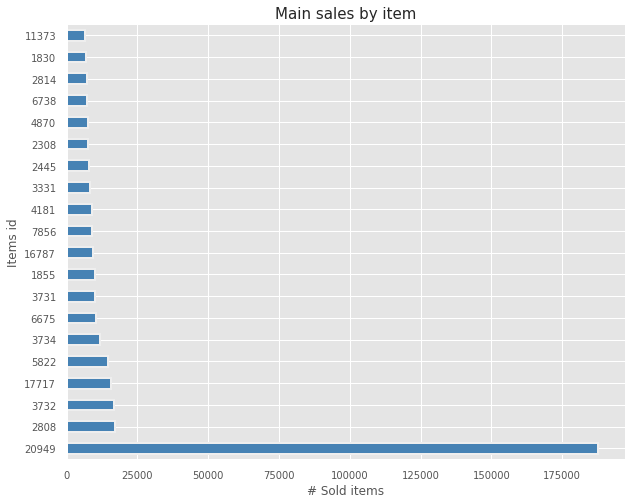

In [10]:
plt.figure(figsize=(10,8))
train_data.groupby('item_id')['item_cnt_month'].sum().sort_values(ascending=False).head(20)\
.plot.barh(lw=2.0, color='steelblue')
plt.title('Main sales by item',size=15)
plt.xlabel('# Sold items')
plt.ylabel('Items id')
plt.show()

- **Sold items per shop** 

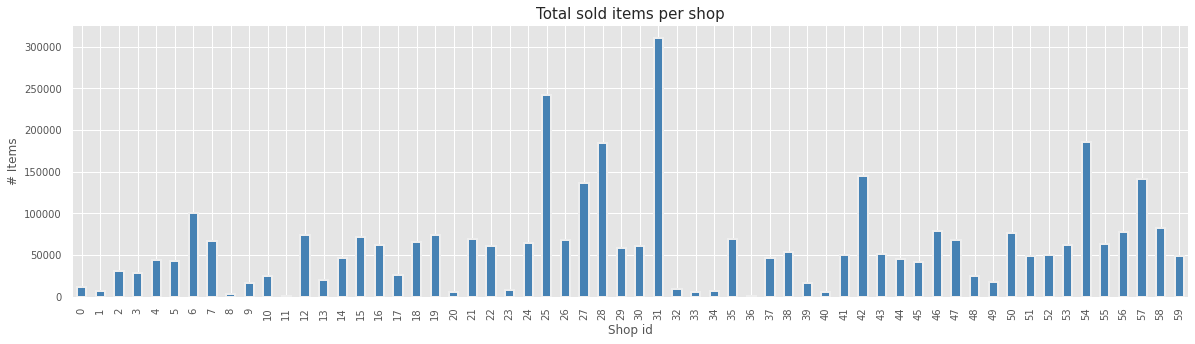

In [11]:
plt.figure(figsize=(20,5))
train_data.groupby('shop_id')['item_cnt_month'].sum().plot.bar(lw=2.0, color='steelblue')
plt.title('Total sold items per shop',size=15)
plt.xlabel('Shop id')
plt.ylabel('# Items')
plt.show()

- **Sold items per shop and category** 

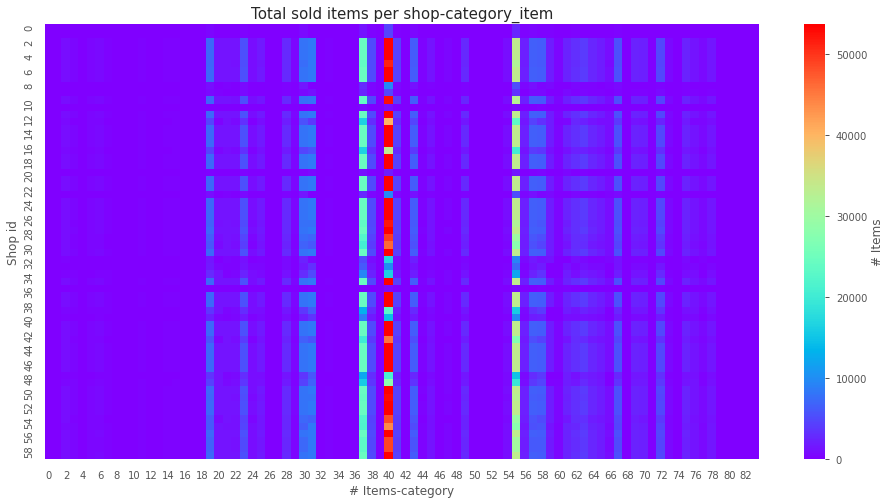

In [12]:
## adding extra information
data_to_plot = train_data.merge(items_raw,on=['item_id'],how='left').copy()
data_to_plot = data_to_plot.merge(item_categories_raw, on=['item_category_id'], how='left')

heatmap = data_to_plot.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heatmap, cmap='rainbow', ax=ax, cbar=True, cbar_kws={'label': '# Items'})
plt.title('Total sold items per shop-category_item',size=15)
plt.ylabel('Shop id')
plt.xlabel('# Items-category')
plt.show()

del data_to_plot
gc.collect();

- **Time series for target variable** 

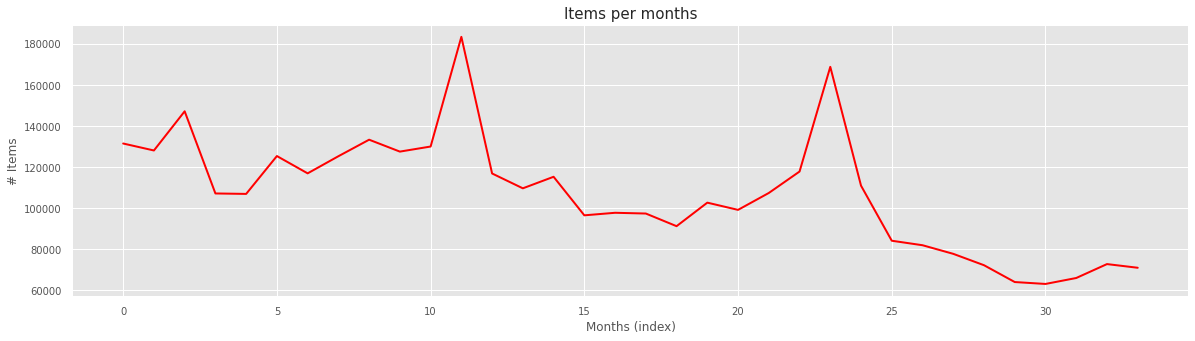

In [13]:
plt.figure(figsize=(20,5))
train_data.groupby('date_block_num')['item_cnt_month'].sum().plot( lw=2.0, color='r')
plt.title('Items per months',size=15)
plt.xlabel('Months (index)')
plt.ylabel('# Items')
plt.show()

## 4. Data Enrichment

In [14]:
#Add test data for data preprocessing and feature engineerig 
test_data = test_raw.drop(columns='ID').copy()
test_data['date_block_num'] = 34
train_test = pd.concat([train_data,test_data], axis=0, ignore_index=True)\
            .sort_values(by='date_block_num', ascending=True).reset_index(drop=True)\
            .fillna(-999) #fill temporaly test 

#Add extra information (item_category_id)
train_test = train_test.merge(items_raw[['item_id','item_category_id']], on='item_id', how='left')
ord_cols = ['date_block_num','shop_id','item_id','item_category_id','item_cnt_month']
train_test = train_test[ord_cols]

#downcast to save memory
train_test['date_block_num'] = train_test['date_block_num'].astype(np.uint8)  ##downcast to save memory
train_test['shop_id'] = train_test['shop_id'].astype(np.uint8)
train_test['item_category_id'] = train_test['item_category_id'].astype(np.uint8)
train_test['item_id'] = train_test['item_id'].astype(np.uint16)
train_test['item_cnt_month'] = train_test['item_cnt_month'].astype(np.int16)

display(train_test.head(), train_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   date_block_num    uint8 
 1   shop_id           uint8 
 2   item_id           uint16
 3   item_category_id  uint8 
 4   item_cnt_month    int16 
dtypes: int16(1), uint16(1), uint8(3)
memory usage: 159.2 MB


,date_block_num,shop_id,item_id,item_category_id,item_cnt_month
0,0,59,22154,37,1
1,0,35,2565,56,0
2,0,35,2564,59,0
3,0,35,2555,56,0
4,0,35,2554,58,0


None

In [15]:
del test_data, test_raw, train_data
gc.collect();

### 4.1. Text feature extraction

In [16]:
#TfidfVectorizer from descriptions
feature_cnt = 20

# feature extraction on ITEMS
items = items_raw.copy()
items['item_name_len'] = items_raw['item_name'].map(len).astype(np.uint32) #lenth of description
items['item_name_wordcount'] = items_raw['item_name'].map(lambda x: len(str(x).split(' '))).astype(np.uint32) #word count of description
tfidf = text.TfidfVectorizer(max_features=feature_cnt)
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]].astype(np.float32)
items = items.drop(columns='item_name')

# feature extraction on CATEGORY-ITEM
item_categories = item_categories_raw.copy()
item_categories['item_category_name_len'] = item_categories['item_category_name'].map(len).astype(np.uint32) #lenth of description
item_categories['item_category_name_wordcount'] = item_categories['item_category_name'].map(lambda x: len(str(x).split(' '))).astype(np.uint32) #word count of description
tfidf = text.TfidfVectorizer(max_features=feature_cnt)
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_categories['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_categories['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]].astype(np.float32)
item_categories = item_categories.drop(columns='item_category_name')

# feature extraction on SHOP
shops = shops_raw.copy()
shops['shop_name_len'] = shops['shop_name'].map(len).astype(np.uint32) #lenth of description
shops['shop_name_wordcount'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))).astype(np.uint32) #word count of description
tfidf = text.TfidfVectorizer(max_features=feature_cnt)
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]].astype(np.float32)
shops = shops.drop(columns='shop_name')


display(items.head(),item_categories.head(),shops.head())

del cols, items_raw, item_categories_raw, shops_raw
gc.collect();

,item_id,item_category_id,item_name_len,item_name_wordcount,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19
0,0,40,41,14,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,76,68,9,0.0,0.0,0.0,0.0,0.637898,0.0,0.0,0.0,0.442678,0.0,0.0,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,2,40,45,26,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,40,47,26,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,40,43,25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


,item_category_id,item_category_name_len,item_category_name_wordcount,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19
0,0,23,3,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,16,3,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,16,3,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,16,3,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,16,3,0.0,0.0,0.780837,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,shop_id,shop_name_len,shop_name_wordcount,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19
0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,1,29,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,2,16,3,0.0,0.0,0.0,0.0,0.0,0.866844,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,3,30,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,4,24,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.905675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


In [17]:
#months from date_block_num
month_oh = train_test[['date_block_num']].copy()
month_oh['date_day']='2013-01-01'
month_oh['date_day'] = pd.to_datetime(month_oh['date_day'], format="%Y-%m")
for month in month_oh['date_block_num'].unique():
    month_oh.loc[month_oh['date_block_num']==month,'date_day'] = month_oh.loc[month_oh['date_block_num']==month,'date_day']\
                                                                + pd.offsets.MonthOffset(month)
month_oh = month_oh.drop_duplicates(subset=['date_block_num','date_day']).reset_index(drop=True)    
month_oh['month_name'] = month_oh.date_day.apply(lambda x: x.strftime("%b"))    
month_oh = pd.get_dummies(month_oh, dummy_na=True,dtype=np.uint8, prefix='',prefix_sep='')\
            .drop(columns=['nan','date_day'])    
month_oh.head()    

,date_block_num,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,1,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,1,0,0,0


### 4.2. Categorical encoding

In [18]:
# Mean encoding on item_id, shop_id and item_category_id.
# Regularization withh cv-loop

cat_to_encod = ['item_id','shop_id','item_category_id']
df_ce = train_test.reset_index(drop=True).copy()

df_ce.loc[df_ce['date_block_num']==34,'item_cnt_month'] = np.nan

cv = KFold(n_splits=5, shuffle=False)
encod_features = []
for train_idx, valid_idx in cv.split(df_ce):
    X_train, X_valid = df_ce.iloc[train_idx,:].copy(), df_ce.iloc[valid_idx,:].copy()
    
    for col in cat_to_encod:
        # encoding: mean
        average_num = X_valid[col].map(X_train.groupby(col)['item_cnt_month'].mean())
        col_new = col+'_mean_target_enc'
        X_valid[col_new] = average_num
        df_ce.loc[valid_idx, col_new] = X_valid
        encod_features.append(col_new)
        # encoding: standard deviation
        std_num = X_valid[col].map(X_train.groupby(col)['item_cnt_month'].std())
        col_new = col+'_std_target_enc'
        X_valid[col_new] = std_num
        df_ce.loc[valid_idx, col_new] = X_valid
        encod_features.append(col_new)
encod_features = list(set(encod_features))        
print ('New features, ', encod_features)

for new_col in encod_features:
    df_ce[new_col] = df_ce[new_col].astype(np.float32)

display(df_ce.head())

del X_train, X_valid
gc.collect();

New features,  ['item_id_std_target_enc', 'item_category_id_mean_target_enc', 'shop_id_std_target_enc', 'item_category_id_std_target_enc', 'shop_id_mean_target_enc', 'item_id_mean_target_enc']


,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,item_id_mean_target_enc,item_id_std_target_enc,shop_id_mean_target_enc,shop_id_std_target_enc,item_category_id_mean_target_enc,item_category_id_std_target_enc
0,0,59,22154,37,1.0,0.084746,0.298522,0.209270,1.447185,0.174779,0.737685
1,0,35,2565,56,0.0,NaN,NaN,0.302751,2.105169,0.093363,0.565102
2,0,35,2564,59,0.0,0.040619,0.216325,0.302751,2.105169,0.052208,0.264505
3,0,35,2555,56,0.0,0.057491,0.232982,0.302751,2.105169,0.093363,0.565102
4,0,35,2554,58,0.0,NaN,NaN,0.302751,2.105169,0.045567,0.243623


### 4.3. Rolling features

_Note: Due to memory allocation problem on my computer, from now to the end, I'll work with a reduced dataframe, especifically from 2014-10._ 

In [19]:
# REDUCED DATA
train_test['date_day']='2013-01-01'
train_test['date_day'] = pd.to_datetime(train_test['date_day'], format="%Y-%m")
for month in train_test['date_block_num'].unique():
    train_test.loc[train_test['date_block_num']==month,'date_day'] = train_test.loc[train_test['date_block_num']==month,'date_day']\
                                                                + pd.offsets.MonthOffset(month)
cut_off = '2014-10-01'
train_test_reduced =  train_test[train_test['date_day']>=cut_off].copy()
train_test_reduced = train_test_reduced.drop(columns='date_day').reset_index(drop=True)
train_test_reduced.head()

,date_block_num,shop_id,item_id,item_category_id,item_cnt_month
0,21,50,4370,30,0
1,21,50,6595,25,0
2,21,50,580,77,0
3,21,50,6581,25,0
4,21,50,8919,37,0


In [20]:
del train_test
gc.collect();

- **Lag features** 

In [21]:
# 1, 2 and 3 offset months
train_test_lag = train_test_reduced.drop(columns='item_category_id').copy()
train_test_lag = train_test_lag.set_index('date_block_num')

lags = [1,2,3]
lag_features = []
for period in lags:
    shifted = train_test_lag[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id']).shift(period)
    col_lag = 'item_cnt_month_lag_'+str(period)
    train_test_lag[col_lag] = shifted.fillna(0).astype(np.int16)
    lag_features.append(col_lag)

train_test_lag

,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
date_block_num,,,,,,
21,50,4370,0,0,0,0
21,50,6595,0,0,0,0
21,50,580,0,0,0,0
21,50,6581,0,0,0,0
21,50,8919,0,0,0,0
...,...,...,...,...,...,...
34,21,5232,-999,0,1,2
34,21,5268,-999,0,0,0
34,21,5039,-999,1,1,3


In [22]:
del train_test_reduced
gc.collect();

- **Historic average features**

In [23]:
# last 3 months
train_test_lag['item_avg3_month'] = train_test_lag[lag_features].mean(axis=1).astype(np.float32)
train_test_lag

,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_avg3_month
date_block_num,,,,,,,
21,50,4370,0,0,0,0,0.000000
21,50,6595,0,0,0,0,0.000000
21,50,580,0,0,0,0,0.000000
21,50,6581,0,0,0,0,0.000000
21,50,8919,0,0,0,0,0.000000
...,...,...,...,...,...,...,...
34,21,5232,-999,0,1,2,1.000000
34,21,5268,-999,0,0,0,0.000000
34,21,5039,-999,1,1,3,1.666667


- **Historic trend features**

In [24]:
# last 3 months
train_test_lag['item_trend3_month'] = (train_test_lag['item_cnt_month_lag_1']-train_test_lag['item_cnt_month_lag_3'])\
                                        /train_test_lag['item_cnt_month_lag_1']
train_test_lag['item_trend3_month'] = train_test_lag['item_trend3_month'].fillna(0).astype(np.float32)
train_test_lag

,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_avg3_month,item_trend3_month
date_block_num,,,,,,,,
21,50,4370,0,0,0,0,0.000000,0.0
21,50,6595,0,0,0,0,0.000000,0.0
21,50,580,0,0,0,0,0.000000,0.0
21,50,6581,0,0,0,0,0.000000,0.0
21,50,8919,0,0,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...
34,21,5232,-999,0,1,2,1.000000,-inf
34,21,5268,-999,0,0,0,0.000000,0.0
34,21,5039,-999,1,1,3,1.666667,-2.0


### 4.4. Final dataset

In [25]:
#JOIN ALL DATA
#add rolling featues
df = train_test_lag.reset_index().copy()
df['date_block_num'] = df['date_block_num'].astype(np.uint8)
df['item_cnt_month_lag_1'] = df['item_cnt_month_lag_1'].astype(np.int16)
df['item_cnt_month_lag_2'] = df['item_cnt_month_lag_2'].astype(np.int16)
df['item_cnt_month_lag_3'] = df['item_cnt_month_lag_3'].astype(np.int16)
df['item_avg3_month'] = df['item_avg3_month'].astype(np.float32)
df['item_trend3_month'] = df['item_trend3_month'].astype(np.float32)
del train_test_lag
gc.collect();
#add categorical encodings
df = df.merge(df_ce.drop(columns=['item_cnt_month','item_category_id']), on=['date_block_num', 'shop_id', 'item_id'], how='left')
del df_ce
gc.collect();
#add text features
df = df.merge(month_oh, on=['date_block_num'], how='left')
df = df.merge(items, on=['item_id'], how='left')
df = df.merge(item_categories, on=['item_category_id'], how='left')
df = df.merge(shops, on=['shop_id'], how='left')
del month_oh, items, item_categories, shops
gc.collect();

df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_avg3_month,item_trend3_month,item_id_mean_target_enc,item_id_std_target_enc,shop_id_mean_target_enc,shop_id_std_target_enc,item_category_id_mean_target_enc,item_category_id_std_target_enc,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,item_category_id,item_name_len,item_name_wordcount,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_category_name_len,item_category_name_wordcount,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,shop_name_len,shop_name_wordcount,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19
0,21,50,4370,0,0,0,0,0.0,0.0,1.544372,2.143594,0.346667,2.011804,1.218252,5.115255,0,0,0,0,0,0,0,0,0,0,1,0,30,50,7,0.000000,0.0,0.0,0.0,0.0,0.772083,0.0,0.0,0.635522,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,29,5,0.0,0.621239,0.0,0.000000,0.0,0.000000,0.0,0.0,0.434298,0.652263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.905675,0.0,0.0
1,21,50,6595,0,0,0,0,0.0,0.0,0.186813,0.462518,0.346667,2.011804,0.276354,0.758471,0,0,0,0,0,0,0,0,0,0,1,0,25,47,5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,25,5,0.0,0.000000,0.0,0.000000,0.0,0.786047,0.0,0.0,0.618166,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.905675,0.0,0.0
2,21,50,580,0,0,0,0,0.0,0.0,0.020408,0.142857,0.346667,2.011804,0.119710,0.559169,0,0,0,0,0,0,0,0,0,0,1,0,77,98,10,0.471448,0.0,0.0,0.0,0.0,0.442765,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.534513,0.544052,0.0,0.0,0.0,0.0,0.0,21,3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.905675,0.0,0.0
3,21,50,6581,0,0,0,0,0.0,0.0,0.234004,0.513637,0.346667,2.011804,0.276354,0.758471,0,0,0,0,0,0,0,0,0,0,1,0,25,42,4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,25,5,0.0,0.000000,0.0,0.000000,0.0,0.786047,0.0,0.0,0.618166,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.905675,0.0,0.0
4,21,50,8919,0,0,0,0,0.0,0.0,0.138539,0.380657,0.346667,2.011804,0.182838,0.771419,0,0,0,0,0,0,0,0,0,0,1,0,37,22,4,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,14,3,0.0,0.000000,0.0,0.757421,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.652927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.905675,0.0,0.0


In [27]:
# TRAIN-TEST SPLIT
## Hold-out validation schema
features = [x for x in df.columns if x not in ['item_cnt_month']]
target = 'item_cnt_month'
X = df[features]
y = df[target]

lags = [1,2,3]
gap = len(lags)#3
X_train = X[(X['date_block_num']>X['date_block_num'].min()+gap) & (X['date_block_num']<34-gap)]
X_test = X[X['date_block_num']==34]
y_train = y[(X['date_block_num']>X['date_block_num'].min()+gap) & (X['date_block_num']<34-gap)]
y_test = y[X['date_block_num']==34]
            
print('Month range for train: ', X_train['date_block_num'].max() - X_train['date_block_num'].min())
print('i.e., in this particular case, from 2015-Feb to 2015-Jul')
del df, X, y
gc.collect();

print('\nX_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)

Month range for train:  5
i.e., in this particular case, from 2015-Feb to 2015-Jul

X_train shape:  (1507264, 93)
X_test shape:  (214200, 93)


In [28]:
#SAVE DATA
PREPROCESS_PATH = './data/preprocess/'
X_train.to_csv(os.path.join(PREPROCESS_PATH,'data_train.csv'), index=False)
y_train.to_csv(os.path.join(PREPROCESS_PATH,'y_train.csv'), index=False)
del X_train, y_train
gc.collect();

X_test.to_csv(os.path.join(PREPROCESS_PATH,'data_test.csv'), index=False)
y_test.to_csv(os.path.join(PREPROCESS_PATH,'y_test.csv'), index=False)
del X_test, y_test
gc.collect();